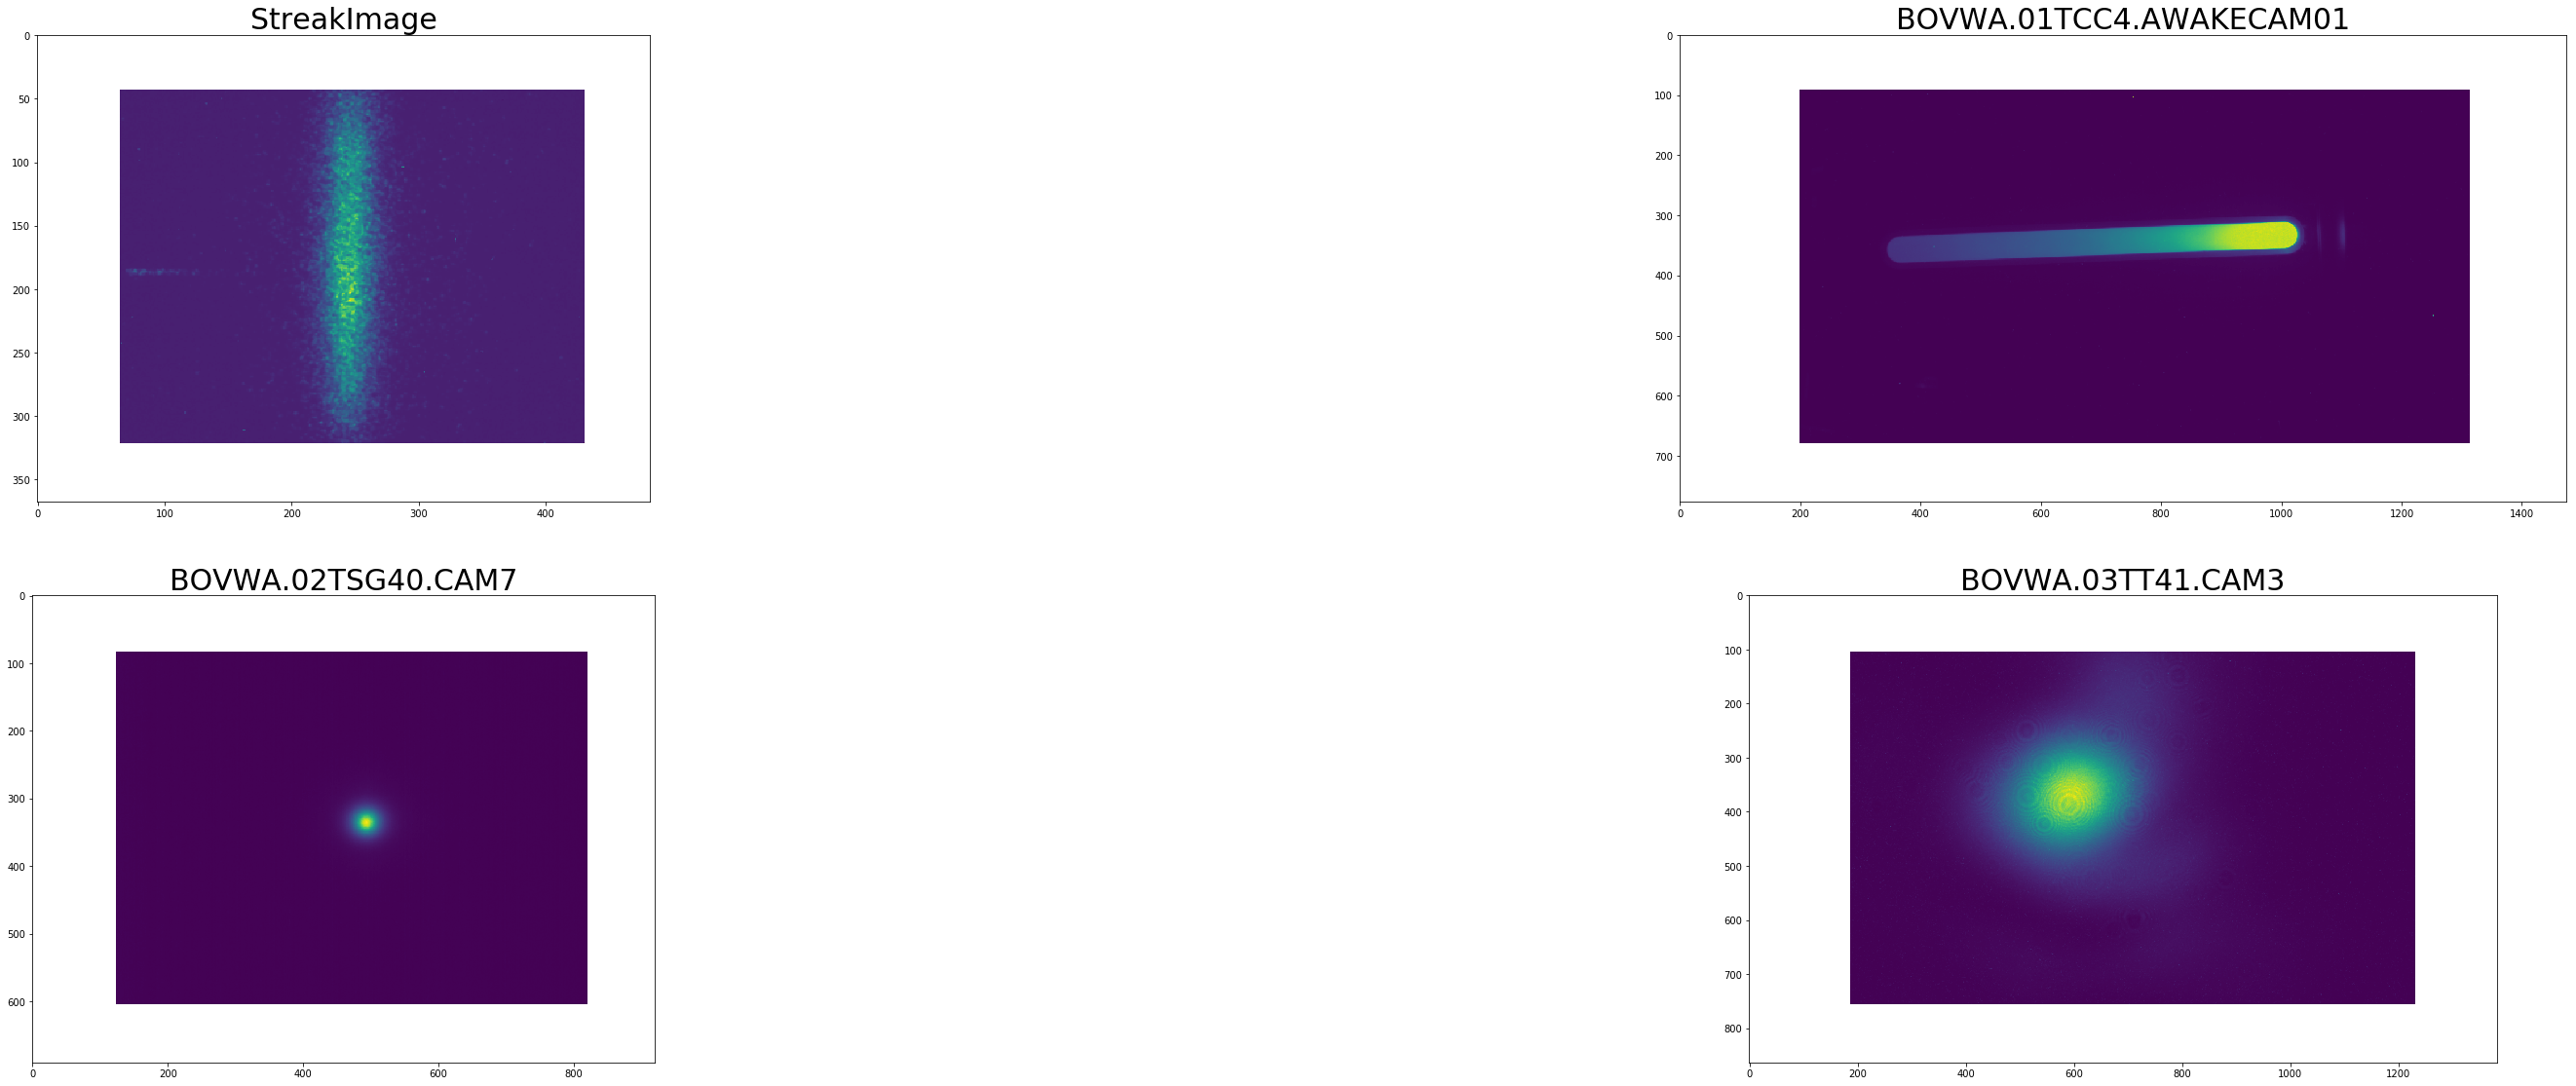

In [30]:
import os
import h5py
from datetime import datetime
import pytz
import csv
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.signal import medfilt2d
from  scipy import ndimage
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import matplotlib.image as mpimg

def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)


def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes is None:
        sizes = range(1, s/2, 2)
    granulo = [ndimage.binary_opening(data, \
            structure=disk_structure(n)).sum() for n in sizes]
    return granulo

def openFile():
    file = 'CSVFiles/csv_all_files.csv'
    file = open(file, "r")
    df = pd.read_csv(file)
    return df

def search_by_dataset_name(df, dataset):
    df = df[df['DatasetName'].str.contains(str(dataset))==True]
    if(len(df) != 1):
        df = df[:1]
    filename = df['DatasetName'].values[0]
    parentGroup = df['GroupName'].values[0]
    H5File = df['HDF5FileName'].values[0]
    file = h5py.File("H5Files"+"/"+str(H5File), 'r')
    parentGroup = file[parentGroup]
    return get_dataset(file, parentGroup)
        

def get_dataset(h5File, parentGroup):
    dataset = {'DatasetName' : h5File.name}
    for file in parentGroup.keys() :
        values = parentGroup[file].name.split("/")
        val = list(parentGroup[file])
        if len(val) == 1 :
            dataset.update({values[len(values)-1] : val[0]})
        else :
            dataset.update({parentGroup.name+"/"+str(values[len(values)-1]) : list(val)})
    return dataset

def getImage(dataset):
    raw_data = dataset["/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData"]
    height = dataset["streakImageHeight"]
    width = dataset["streakImageWidth"]
    
    data = np.reshape(raw_data, (height, width))
    data = medfilt(data)
    fig = plt.figure(figsize=(width/100,height/100))
    ax = fig.add_subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    plt.imshow(data)
    plt.savefig('PNGFiles/DataAnalysis/Fig1.png')
    plt.close()
    
    plt.imshow(data, cmap=plt.cm.gray)
    plt.savefig('PNGFiles/DataAnalysis/Fig2.png')
    plt.close()
    
    rotate_data = ndimage.rotate(data, 90)
    plt.imshow(rotate_data, cmap=plt.cm.gray)
    plt.savefig('PNGFiles/DataAnalysis/Fig3.png')
    plt.close()
    
    blurred_data = ndimage.gaussian_filter(data, sigma=3)
    plt.imshow(blurred_data)
    plt.savefig('PNGFiles/DataAnalysis/Fig4.png')
    plt.close()
    
    #print ('Mean Value : 'data.mean())
    
    showImages()
    
def FindEdges(dataset):
    print("Finding Edges..")
    raw_data = dataset["/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData"]
    height = dataset["streakImageHeight"]
    width = dataset["streakImageWidth"]
    im = np.reshape(raw_data, (height, width))
    im = ndimage.gaussian_filter(im, 8)

    sx = ndimage.sobel(im, axis=0, mode='constant')
    sy = ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)

    plt.imshow(im, cmap=plt.cm.gray)
    plt.savefig('PNGFiles/DataAnalysis/Fig5.png')
    plt.close()
    
    plt.imshow(sob)
    plt.savefig('PNGFiles/DataAnalysis/Fig6.png')
    plt.close()
    
def FindSegments(dataset):
    raw_data = dataset["/AwakeEventData/BOVWA.02TCC4.AWAKECAM02/ExtractionImage/imageRawData"]
    height = dataset["height"]
    width = dataset["width"]
    im = np.reshape(raw_data, (height, width))
    mask = (im > im.mean()).astype(np.float)
    img = mask + 0.3*np.random.randn(*mask.shape)
    binary_img = img > 0.5    
    # Remove small white regions
    open_img = ndimage.binary_opening(binary_img)
    # Remove small black hole
    close_img = ndimage.binary_closing(open_img)

    l = 128

    plt.subplot(141)
    plt.imshow(binary_img[:l, :l], cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(open_img[:l, :l], cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(close_img[:l, :l], cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
    plt.contour(close_img[:l, :l], [0.5], linewidths=2, colors='r')
    plt.axis('off')

    plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)

    plt.show()
    plt.close()
    
def plot_GMM(dataset):
    raw_data = dataset["/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData"]
    height = dataset["streakImageHeight"]
    width = dataset["streakImageWidth"]
    n = 10
    l = 256
    im = np.reshape(raw_data, (height, width))
    im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
    mask = (im > im.mean()).astype(np.float)
    img = mask + 0.3*np.random.randn(*mask.shape)
    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    classif = GaussianMixture(n_components=2)
    classif.fit(img.reshape((img.size, 1)))
    threshold = np.mean(classif.means_)
    binary_img = img > threshold
    plt.figure(figsize=(11,4))
    plt.title('Segmentation with Gaussian Mixture Models', fontsize=30)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(132)
    plt.plot(bin_centers, hist, lw=2)
    plt.axvline(0.5, color='r', ls='--', lw=2)
    plt.text(0.57, 0.8, 'histogram', fontsize=20, transform = plt.gca().transAxes)
    plt.yticks([])
    plt.subplot(133)
    plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')

    plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
    plt.savefig('PNGFiles/DataAnalysis/Plots/Fig1.png')
    plt.close()
    
def plot_granulo(dataset):
    raw_data = dataset["/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData"]
    height = dataset["streakImageHeight"]
    width = dataset["streakImageWidth"]
    n = 10
    l = 256
    im = np.reshape(raw_data, (height, width))
    im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
    mask = im > im.mean()
    granulo = granulometry(mask, sizes=np.arange(2, 19, 4))
    plt.figure(figsize=(10, 4))
    plt.title('Simple Granulatory Analysis', fontsize=30)
    plt.subplot(121)
    plt.imshow(mask, cmap=plt.cm.gray)
    opened = ndimage.binary_opening(mask, structure=disk_structure(10))
    opened_more = ndimage.binary_opening(mask, structure=disk_structure(14))
    plt.contour(opened, [0.5], colors='b', linewidths=2)
    plt.contour(opened_more, [0.5], colors='r', linewidths=2)
    plt.axis('off')
    plt.subplot(122)
    plt.plot(np.arange(2, 19, 4), granulo, 'ok', ms=8)
    plt.subplots_adjust(wspace=0.02, hspace=0.15, top=0.95, bottom=0.15, left=0, right=0.95)
    plt.savefig('PNGFiles/DataAnalysis/Plots/Fig2.png')
    plt.close()
    
def plot_propogation(dataset):
    raw_data = dataset["/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData"]
    height = dataset["streakImageHeight"]
    width = dataset["streakImageWidth"]
    square = np.reshape(raw_data, (height, width))
    open_square = ndimage.binary_opening(square)
    eroded_square = ndimage.binary_erosion(square)
    reconstruction = ndimage.binary_propagation(eroded_square, mask=square)
    plt.figure(figsize=(9.5, 3))
    plt.subplot(131)
    plt.imshow(square, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(open_square, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(reconstruction, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0.02, top=0.99, bottom=0.01, left=0.01, right=0.99)
    plt.show()
    plt.close()

def showImages():
    images = []
    for img_path in glob.glob('PNGFiles/*.png'):
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(60,30))
    columns = 2
    val=0
    title = ["StreakImage", "BOVWA.01TCC4.AWAKECAM01", "BOVWA.02TSG40.CAM7", "BOVWA.03TT41.CAM3"]
    #title = ["NORMAL IMAGE", "IMAGE IN GRAYSCALE", "IMAGE ROTATED BY 90 DEGREES", "DENOISED IMAGE THAT WAS BLURRED", "SQUARE FILTER EDGE DETECTION", "SOBEL FILTER EDGE DETECTION"]
    #title = ["Segmentation with Gaussian Mixture Models", "Simple Granulatory Analysis"]
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.title(title[val], fontsize=30)
        #plt.axis('off')
        plt.imshow(image)
        val=val+1

def gaussian(x, mu, sigma, amp):
    return amp*np.exp( -(x - mu)**2 / (2.*sigma**2))

def optimize_curve():
    img = mpimg.imread('PNGFiles/Dataset1.png')
    hist,bins,_ = plt.hist(img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
    bin_centers = np.mean([bins[:-1],bins[1:]], axis=0)
    p_opt,_ = curve_fit(gaussian, bin_centers, hist, maxfev=1000000)
    mu, sigma, amp = p_opt
    fit = gaussian(bin_centers, mu, sigma, amp)
#   plt.plot(bin_centers, hist)
#   plt.plot(bin_centers, fit)
#   plt.imshow(img)
    print("StreakImage Data")
    print("Optional values for the parameters so that the sum of squared residuals of function is minimized.")
    print (p_opt)
    print("Estimated Covariance Matrix. The diagonals provide the variance of the parameter estimte.")
    print (_)
    

df = openFile()
#optimize_curve()
#val = search_by_dataset_name(df, "/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData")
#val = search_by_dataset_name(df, "/AwakeEventData/BOVWA.02TCC4.AWAKECAM02/ExtractionImage/imageRawData")
#getImage(val)
#FindEdges(val)
#FindSegments(val)
#plot_GMM(val)
#plot_granulo(val)
showImages()